## Setup & Load Dataset


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize
import nltk
import json
!pip install tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

df = pd.read_csv('/content/financial_sentiment_merged.csv')


with open('/content/vocabulary.json', 'r') as f:
    vocab_json = json.load(f)
print(df[['Cleaned']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                             Cleaned
0  geosolutions technology leverage benefon gps s...
1                           esi low real possibility
2  last quarter 2010 componenta net sale doubled ...
3  according finnishrussian chamber commerce majo...
4  swedish buyout firm sold remaining percent sta...


Preprocess & Tokenization

In [ ]:
tokenized_sentences = df['Cleaned'].dropna().apply(word_tokenize)

corpus = tokenized_sentences.tolist()

print("Sample tokenized sentence:", corpus[0])
print("Total sentences:", len(corpus))

Sample tokenized sentence: ['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'technology', 'community', 'platform', 'location', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model']
Total sentences: 43858


Build Vocabulary and Word-Index Mappings

In [ ]:
word2idx = vocab_json['word2idx']
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(word2idx)



idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(word2idx)
print("Vocabulary Size:", vocab_size)
print("Sample word2idx:", dict(list(word2idx.items())[:10]))

Vocabulary Size: 36212
Sample word2idx: {'<PAD>': 0, '<UNK>': 1, 'geosolutions': 2, 'technology': 3, 'leverage': 4, 'benefon': 5, 'gps': 6, 'solution': 7, 'providing': 8, 'location': 9}


# Generate Skip-Gram Training Pairs

In [ ]:
corpus = df['Cleaned'].dropna().apply(word_tokenize).tolist()

window_size = 2
training_pairs = []

# Here we are generating (center, context) pairs
for sentence in corpus:
    sentence = [word for word in sentence if word in word2idx]  # filter out unknown words
    for center_pos in range(len(sentence)):
        center_word = sentence[center_pos]
        for offset in range(-window_size, window_size + 1):
            context_pos = center_pos + offset
            if context_pos < 0 or context_pos >= len(sentence) or offset == 0:
                continue
            context_word = sentence[context_pos]
            training_pairs.append((word2idx[center_word], word2idx[context_word]))

print(f"Total training pairs: {len(training_pairs)}")
print("Sample pairs (center idx, context idx):", training_pairs[:5])


Total training pairs: 1339664
Sample pairs (center idx, context idx): [(2, 3), (2, 4), (3, 2), (3, 4), (3, 5)]


## Define and train the embedding model using PyTorch.

In [ ]:
embedding_dim = 100

# Defininng Skip-Gram Model
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center_words):
        embeds = self.embedding(center_words)                  # (batch_size, embedding_dim)
        out = self.output(embeds)                              # (batch_size, vocab_size)
        return out

# Initializing model, loss, and optimizer
model = SkipGramModel(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Prepare data for batching and run the training loop.

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os

class Word2VecDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return torch.tensor(self.pairs[idx][0]), torch.tensor(self.pairs[idx][1])

# Move model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Dataloader with optimizations
dataset = Word2VecDataset(training_pairs)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True, num_workers=2)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    with tqdm(dataloader, unit='batch', desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for center, context in pbar:
            center, context = center.to(device), context.to(device)

            optimizer.zero_grad()
            output = model(center)
            loss = criterion(output, context)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pbar.set_postfix(loss=total_loss / (pbar.n + 1))  # Running avg loss

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/5: 100%|██████████| 5234/5234 [00:47<00:00, 111.04batch/s, loss=8.64]


Epoch 1/5, Loss: 45223.6211


Epoch 2/5: 100%|██████████| 5234/5234 [00:47<00:00, 109.38batch/s, loss=7.71]


Epoch 2/5, Loss: 40351.8217


Epoch 3/5: 100%|██████████| 5234/5234 [00:49<00:00, 104.94batch/s, loss=7.38]


Epoch 3/5, Loss: 38621.5986


Epoch 4/5: 100%|██████████| 5234/5234 [00:46<00:00, 111.97batch/s, loss=7.16]


Epoch 4/5, Loss: 37483.5411


Epoch 5/5: 100%|██████████| 5234/5234 [00:47<00:00, 109.41batch/s, loss=7.01]

Epoch 5/5, Loss: 36646.0559


In [ ]:
model.eval()

embedding_weights = model.embedding.weight.data.cpu().numpy()

np.save('/content/word2vec_embeddings.npy', embedding_weights)

print("Word2Vec embedding matrix saved as word2vec_embeddings.npy")


Word2Vec embedding matrix saved as word2vec_embeddings.npy


## FastText

Prepare unique n-grams

In [ ]:
from collections import defaultdict

def generate_ngrams(word, min_n=3, max_n=6):
    ngrams = []
    word = f'<{word}>'
    for n in range(min_n, max_n+1):
        for i in range(len(word)-n+1):
            ngrams.append(word[i:i+n])
    return ngrams

# Build n-gram vocabulary
ngram_to_idx = {}
ngram_freq = defaultdict(int)
ngram_counter = 0

for word in word2idx:
    ngrams = generate_ngrams(word)
    for ng in ngrams:
        if ng not in ngram_to_idx:
            ngram_to_idx[ng] = ngram_counter
            ngram_counter += 1
        ngram_freq[ng] += 1

print("Number of unique n-grams:", len(ngram_to_idx))


Number of unique n-grams: 243211


Training

In [ ]:
class FastTextModel(nn.Module):
    def __init__(self, ngram_vocab_size, embedding_dim, word_vocab_size):
        super(FastTextModel, self).__init__()
        self.ngram_embeddings = nn.Embedding(ngram_vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, word_vocab_size)

    def forward(self, word_ngrams):
        embedded = self.ngram_embeddings(word_ngrams)         # (batch_size, num_ngrams, emb_dim)
        pooled = embedded.mean(dim=1)                          # (batch_size, emb_dim)
        return self.output(pooled)                             # (batch_size, vocab_size)


### Convert center words into n-gram indices

In [ ]:
# Helper: Convert a word into its n-gram index list
def word_to_ngram_indices(word, ngram_to_idx, min_n=3, max_n=6):
    ngrams = generate_ngrams(word, min_n, max_n)
    indices = [ngram_to_idx[ng] for ng in ngrams if ng in ngram_to_idx]
    return indices


class FastTextDataset(Dataset):
    def __init__(self, training_pairs, idx2word, ngram_to_idx):
        self.pairs = training_pairs
        self.idx2word = idx2word
        self.ngram_to_idx = ngram_to_idx

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center_idx, context_idx = self.pairs[idx]
        center_word = idx2word[center_idx]
        ngram_indices = word_to_ngram_indices(center_word, self.ngram_to_idx)
        return torch.tensor(ngram_indices), torch.tensor(context_idx)

# Collate function to pad variable-length n-gram sequences
def fasttext_collate(batch):
    ngram_seqs, contexts = zip(*batch)
    lengths = [len(seq) for seq in ngram_seqs]
    max_len = max(lengths)
    padded = torch.zeros(len(batch), max_len, dtype=torch.long)
    for i, seq in enumerate(ngram_seqs):
        padded[i, :lengths[i]] = seq
    return padded, torch.tensor(contexts)


### Initialize model and train

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fasttext_model = FastTextModel(len(ngram_to_idx), embedding_dim, vocab_size)

# Move model to device
fasttext_model = fasttext_model.to(device)
criterion = criterion.to(device)

optimizer = optim.Adam(fasttext_model.parameters(), lr=0.001)
fasttext_dataset = FastTextDataset(training_pairs, idx2word, ngram_to_idx)
# Optimized DataLoader
fasttext_loader = DataLoader(
    fasttext_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=fasttext_collate,
    pin_memory=True,
    num_workers=2
)

epochs = 5
for epoch in range(epochs):
    fasttext_model.train()
    total_loss = 0.0
    batch_count = 0

    with tqdm(fasttext_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for ngram_inputs, context_targets in pbar:
            # Move data to device
            ngram_inputs = ngram_inputs.to(device)
            context_targets = context_targets.to(device)

            optimizer.zero_grad()
            output = fasttext_model(ngram_inputs)
            loss = criterion(output, context_targets)
            loss.backward()
            optimizer.step()

            batch_count += 1
            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / batch_count)

    print(f"✅ Epoch {epoch+1}/{epochs}, Avg Loss: {total_loss / batch_count:.4f}")

Epoch 1/5: 100%|██████████| 5234/5234 [01:35<00:00, 54.56batch/s, loss=8.47]


✅ Epoch 1/5, Avg Loss: 8.4698


Epoch 2/5: 100%|██████████| 5234/5234 [01:31<00:00, 56.94batch/s, loss=8.05]


✅ Epoch 2/5, Avg Loss: 8.0529


Epoch 3/5: 100%|██████████| 5234/5234 [01:30<00:00, 57.62batch/s, loss=7.79]


✅ Epoch 3/5, Avg Loss: 7.7879


Epoch 4/5: 100%|██████████| 5234/5234 [01:30<00:00, 57.81batch/s, loss=7.58]


✅ Epoch 4/5, Avg Loss: 7.5825


Epoch 5/5: 100%|██████████| 5234/5234 [01:30<00:00, 57.92batch/s, loss=7.41]

✅ Epoch 5/5, Avg Loss: 7.4113


In [ ]:
# Switch to evaluation mode
fasttext_model.eval()

# Embedding dimension and final matrix
embedding_dim = fasttext_model.ngram_embeddings.embedding_dim
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Compute embedding for each word
for word, idx in word2idx.items():
    ngram_indices = word_to_ngram_indices(word, ngram_to_idx)
    if not ngram_indices:
        continue

    ngram_tensor = torch.tensor(ngram_indices).to(device) # Move ngram_tensor to the device
    with torch.no_grad():
        ngram_embeds = fasttext_model.ngram_embeddings(ngram_tensor)
        word_embed = ngram_embeds.mean(dim=0).cpu().numpy()

    embedding_matrix[idx] = word_embed

# Save to .npy file
np.save('/content/fasttext_embeddings.npy', embedding_matrix)

print("Embedding matrix saved as fasttext_embeddings.npy")

Embedding matrix saved as fasttext_embeddings.npy


Analyzing the Embeddings

Running cosine similarity for 3 epochs on sample size 1000
Epoch 1: Avg cosine similarity = -0.0036
Epoch 2: Avg cosine similarity = -0.0036
Epoch 3: Avg cosine similarity = -0.0036

Top 5 Neighbors (cosine similarity) for word index 10:
Index: 441, Similarity: 0.3442
Index: 355, Similarity: 0.3346
Index: 506, Similarity: 0.3091
Index: 588, Similarity: 0.3022
Index: 264, Similarity: 0.2940


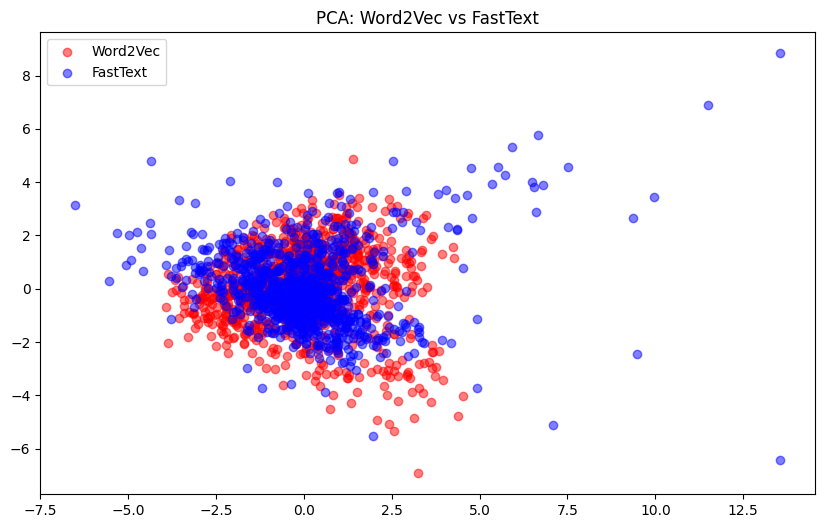

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


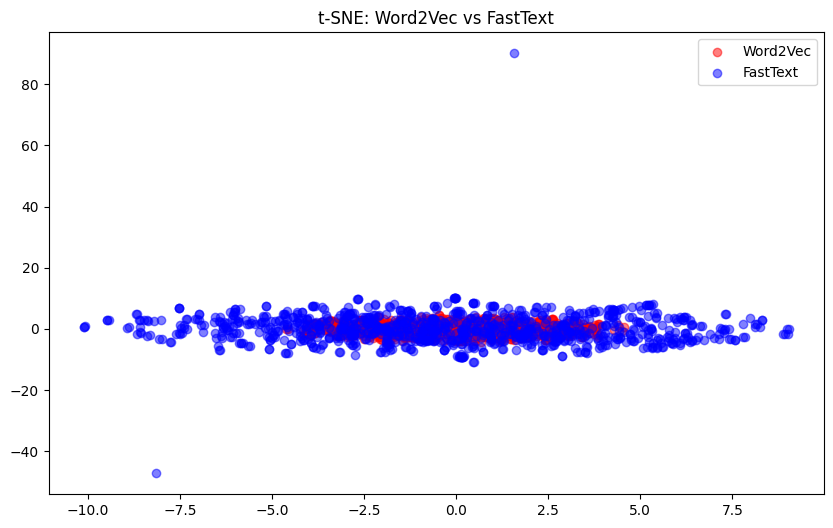

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import pearsonr

word2vec_embeddings = np.load('/content/word2vec_embeddings.npy')


fasttext_embeddings = np.load('/content/fasttext_embeddings.npy')

# Sample size for fast computation
sample_size = 1000
word2vec_sample = word2vec_embeddings[:sample_size]
fasttext_sample = fasttext_embeddings[:sample_size]

# Function: Efficient Cosine Similarity in Batches
def cosine_sim_matrix_batchwise(embedding1, embedding2, batch_size=100):
    sim_scores = []
    for i in range(0, len(embedding1), batch_size):
        batch1 = embedding1[i:i+batch_size]
        sim = cosine_similarity(batch1, embedding2)
        sim_scores.append(sim)
    return np.vstack(sim_scores)

# Simulate epochs for cosine similarity
def cosine_sim_epochs(embed1, embed2, epochs=3):
    print(f"Running cosine similarity for {epochs} epochs on sample size {sample_size}")
    for epoch in range(epochs):
        sim_matrix = cosine_sim_matrix_batchwise(embed1, embed2, batch_size=100)
        print(f"Epoch {epoch+1}: Avg cosine similarity = {np.mean(sim_matrix):.4f}")
    return sim_matrix

# 1. Cosine Similarity (sampled)
cos_sim_matrix = cosine_sim_epochs(word2vec_sample, fasttext_sample, epochs=3)

# 2. Nearest Neighbors (sampled)
def find_nearest_neighbors(embeddings, word_idx, top_n=5):
    sim = cosine_similarity(embeddings, embeddings[word_idx].reshape(1, -1))
    sim_idx = np.argsort(sim.flatten())[::-1][1:top_n+1]
    return sim_idx, sim.flatten()[sim_idx]

word_idx = 10
neighbors, sim_scores = find_nearest_neighbors(word2vec_sample, word_idx)

print(f"\nTop 5 Neighbors (cosine similarity) for word index {word_idx}:")
for idx, score in zip(neighbors, sim_scores):
    print(f"Index: {idx}, Similarity: {score:.4f}")

# 3. Dimensionality Reduction (sampled for speed)
def reduce_and_plot(emb1, emb2, method='pca', title='2D Visualization'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)

    reduced1 = reducer.fit_transform(emb1)
    reduced2 = reducer.fit_transform(emb2)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced1[:, 0], reduced1[:, 1], alpha=0.5, label='Word2Vec', c='red')
    plt.scatter(reduced2[:, 0], reduced2[:, 1], alpha=0.5, label='FastText', c='blue')
    plt.legend()
    plt.title(title)
    plt.show()

# PCA and t-SNE on samples
reduce_and_plot(word2vec_sample, fasttext_sample, method='pca', title='PCA: Word2Vec vs FastText')
reduce_and_plot(word2vec_sample, fasttext_sample, method='tsne', title='t-SNE: Word2Vec vs FastText')
